In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
import numpy as np

In [5]:
class SlowGLU(nn.Module):
    def __init__(self, in_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, in_size)
        self.linear2 = nn.Linear(in_size, in_size)
    
    def forward(self, X):
        return self.linear1(X) * self.linear2(X).sigmoid()

In [6]:
class FastGLU(nn.Module):
    def __init__(self, in_size):
        super().__init__()
        self.in_size = in_size
        self.linear = nn.Linear(in_size, in_size*2)
    
    def forward(self, X):
        out = self.linear(X)
        return out[:, :self.in_size] * out[:, self.in_size:].sigmoid()

In [17]:
X = torch.zeros(10000, 3).random_(0, 2).long()

In [18]:
y = torch.zeros_like(X).float()
condition = X[:, 0] & X[:, 2] == 1
idxs = torch.where(condition)
y[idxs] = X[idxs] * 0.5

train_data = X[:9000], y[:9000]
valid_data = X[9000:], y[9000:]


In [19]:
def train(model, optim, train_data, valid_data, bs, epochs, print_every=None):
    train_X, train_y = train_data
    valid_X, valid_y = valid_data
    num_batches = np.ceil(len(train_X)/bs).astype(int)
    epoch_train_losses = []
    epoch_valid_losses = []
    
    if print_every is None: print_every = epochs//100
    train_losses = []
    valid_losses = []
        
    for epoch in range(epochs):
        train_losses.clear()
        valid_losses.clear()
        
        batch_order = np.random.choice(np.arange(num_batches), size=num_batches, replace=False)
        
        for batch_idx in batch_order:
            batch = train_X[bs*batch_idx:bs*batch_idx+bs]
            target = train_y[bs*batch_idx:bs*batch_idx+bs]
            pred = model(batch.float())
            loss = F.mse_loss(pred, target)
            train_losses.append(loss.data)
            
            with torch.no_grad():
                valid_loss = F.mse_loss(model(valid_X.float()), valid_y)
                valid_losses.append(valid_loss)

            optim.zero_grad()
            loss.backward()
            optim.step()
            
        if epoch % print_every == 0:
            print(f"epoch {epoch} train: {np.mean(train_losses):.10f}, valid: {np.mean(valid_losses):.10f}", )
            train_losses.clear()
            valid_losses.clear()
            
        epoch_train_losses.append(np.mean(train_losses))
        epoch_valid_losses.append(np.mean(valid_losses))
            
    if len(train_losses) > 0:
        print(f"epoch {epoch} train: {np.mean(train_losses):.10f}, valid: {np.mean(valid_losses):.10f}", )
    
    return epoch_train_losses, epoch_valid_losses

In [20]:
slow_glu = SlowGLU(3)
slow_glu_adam = Adam(slow_glu.parameters(), lr=0.0001)

In [23]:
slow_glu_train_loss, slow_glu_valid_loss = train(
    slow_glu, slow_glu_adam, train_data, valid_data, bs=128, epochs=2000, print_every=200)

epoch 0 train: 0.0048214295, valid: 0.0047777868
epoch 200 train: 0.0013682729, valid: 0.0013618881
epoch 400 train: 0.0003399515, valid: 0.0003378249
epoch 600 train: 0.0000748925, valid: 0.0000738929
epoch 800 train: 0.0000157790, valid: 0.0000155058
epoch 1000 train: 0.0000033394, valid: 0.0000032758
epoch 1200 train: 0.0000007690, valid: 0.0000007538
epoch 1400 train: 0.0000002349, valid: 0.0000002301
epoch 1600 train: 0.0000001095, valid: 0.0000001072
epoch 1800 train: 0.0000000674, valid: 0.0000000660
epoch 1999 train: 0.0000000484, valid: 0.0000000473


In [24]:
fast_glu = FastGLU(3)
fast_glu_adam = Adam(fast_glu.parameters(), lr=0.0001)

In [25]:
fast_glu_train_loss, fast_glu_valid_loss = train(
    fast_glu, fast_glu_adam, train_data, valid_data, bs=128, epochs=2000, print_every=200)

epoch 0 train: 0.0809363276, valid: 0.0793271661
epoch 200 train: 0.0073858574, valid: 0.0072822864
epoch 400 train: 0.0026037351, valid: 0.0025953974
epoch 600 train: 0.0008870867, valid: 0.0008887923
epoch 800 train: 0.0002308462, valid: 0.0002293979
epoch 1000 train: 0.0000514524, valid: 0.0000507214
epoch 1200 train: 0.0000109316, valid: 0.0000107372
epoch 1400 train: 0.0000023569, valid: 0.0000023117
epoch 1600 train: 0.0000005696, valid: 0.0000005582
epoch 1800 train: 0.0000001911, valid: 0.0000001871
epoch 1999 train: 0.0000000992, valid: 0.0000000971


In [59]:
linear = nn.Sequential(
    nn.Linear(3, 3),
    nn.ReLU(),
    nn.Linear(3, 3),
)
linear_adam = Adam(linear.parameters(), lr=0.0001)

In [60]:
linear_relu_train_loss, linear_relu_valid_loss = train(
    linear, linear_adam, train_data, valid_data, bs=128, epochs=2000, print_every=200)

epoch 0 train: 0.3560184836, valid: 0.3545449078
epoch 200 train: 0.0119723389, valid: 0.0119586093
epoch 400 train: 0.0117478333, valid: 0.0117423395
epoch 600 train: 0.0117474115, valid: 0.0117432689
epoch 800 train: 0.0117478296, valid: 0.0117449230
epoch 1000 train: 0.0117470939, valid: 0.0117461924
epoch 1200 train: 0.0117498320, valid: 0.0117450673
epoch 1400 train: 0.0117477914, valid: 0.0117480811
epoch 1600 train: 0.0117462939, valid: 0.0117437290
epoch 1800 train: 0.0117467428, valid: 0.0117432317
epoch 1999 train: 0.0117451455, valid: 0.0117471023


As we can see the network got stuck quite early, very likely because of dying relus.. lets check it!

In [61]:
linear.zero_grad()
preds = linear(train_data[0].float())
loss = F.mse_loss(preds, train_data[1])
loss.backward()

In [62]:
[p.grad.view(-1) for p in linear.parameters()]

[tensor([ 4.5274e-04,  3.5339e-04,  4.1987e-04, -5.8980e-04, -4.5978e-04,
         -5.0463e-04,  0.0000e+00,  5.0709e-05,  5.0709e-05]),
 tensor([ 7.0940e-04, -9.0802e-04,  5.0710e-05]),
 tensor([-3.8893e-04, -1.0020e-03, -2.6653e-05, -4.5647e-05, -4.6542e-05,
          2.0278e-05, -3.8893e-04, -1.0020e-03, -2.6653e-05]),
 tensor([-8.9390e-04, -5.6400e-05, -8.9390e-04])]

It seems we have 1 dead relu (gradient 0).

In [64]:
linear_sigmoid = nn.Sequential(
    nn.Linear(3, 3),
    nn.Sigmoid(),
    nn.Linear(3, 3),
)
linear_sigmoid_adam = Adam(linear_sigmoid.parameters(), lr=0.0001)

In [65]:
linear_sigmoid_train_loss, linear_sigmoid_valid_loss = train(
    linear_sigmoid, linear_sigmoid_adam, train_data, valid_data, bs=128, epochs=2000, print_every=200)

epoch 0 train: 0.0983552039, valid: 0.0979729518
epoch 200 train: 0.0157634225, valid: 0.0155895408
epoch 400 train: 0.0116852056, valid: 0.0115710180
epoch 600 train: 0.0073192818, valid: 0.0072577824
epoch 800 train: 0.0040466255, valid: 0.0040185540
epoch 1000 train: 0.0011111370, valid: 0.0011259363
epoch 1200 train: 0.0002273393, valid: 0.0002315787
epoch 1400 train: 0.0000606720, valid: 0.0000618897
epoch 1600 train: 0.0000225340, valid: 0.0000229714
epoch 1800 train: 0.0000116206, valid: 0.0000118232
epoch 1999 train: 0.0000075228, valid: 0.0000076587


The problem with the relus doesn't happen always as we can see here (it depends on the random initialization). When it works, it works amazing.

In [66]:
linear2 = nn.Sequential(
    nn.Linear(3, 3),
    nn.ReLU(),
    nn.Linear(3, 3),
)
linear2_adam = Adam(linear2.parameters(), lr=0.0001)

In [67]:
linear2_relu_train_loss, linear2_relu_valid_loss = train(
    linear2, linear2_adam, train_data, valid_data, bs=128, epochs=2000, print_every=200)

epoch 0 train: 0.2441937625, valid: 0.2423610091
epoch 200 train: 0.0029769249, valid: 0.0029756960
epoch 400 train: 0.0000000000, valid: 0.0000000000
epoch 600 train: 0.0000000000, valid: 0.0000000000
epoch 800 train: 0.0000000000, valid: 0.0000000000
epoch 1000 train: 0.0000000003, valid: 0.0000000003
epoch 1200 train: 0.0000000007, valid: 0.0000000007
epoch 1400 train: 0.0000000000, valid: 0.0000000000
epoch 1600 train: 0.0000000000, valid: 0.0000000000
epoch 1800 train: 0.0000000000, valid: 0.0000000000
epoch 1999 train: 0.0000000001, valid: 0.0000000001


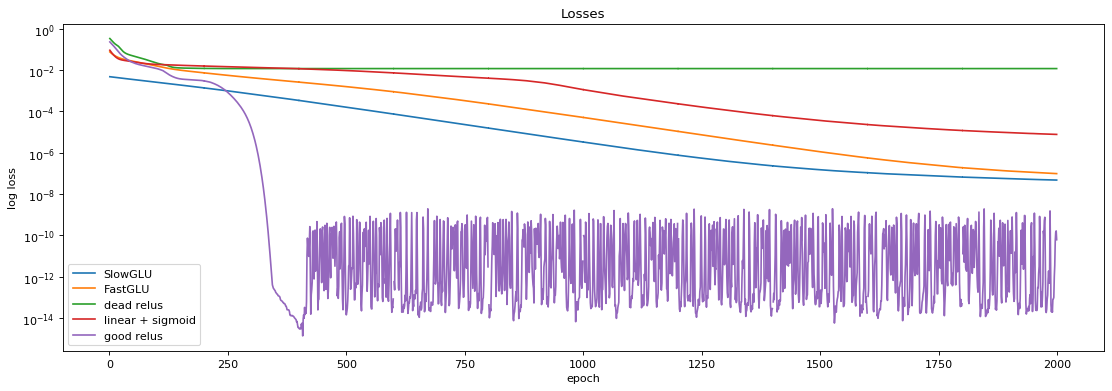

In [81]:
epochs = range(2000)
plt.figure(figsize=(14,5), dpi=80)
plt.plot(epochs, slow_glu_valid_loss, label="SlowGLU")
plt.plot(epochs, fast_glu_valid_loss, label="FastGLU")
plt.plot(epochs, linear_relu_valid_loss, label="dead relus")
plt.plot(epochs, linear_sigmoid_valid_loss, label="linear + sigmoid")
plt.plot(epochs, linear2_relu_valid_loss, label="good relus")
plt.legend()
plt.yscale("log")
plt.ylabel("log loss")
plt.xlabel("epoch")
plt.title("Losses")
plt.tight_layout()